Retrieval

Il task è trovare all’interno di un dataset fornito dal docente i 10 volti
che somigliano di più a quello del punto precedente

I 10 risultati restituiti devono essere ordinati per similarità
decrescente

In [83]:
import os
from matplotlib import pyplot as plt
from time import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2 as cv # pip install opencv-python


from keras.applications import resnet50, xception, vgg16, inception_resnet_v2
from keras.preprocessing import image as kimage
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, GlobalAveragePooling2D, ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.models import Model, load_model, model_from_json
from keras import optimizers
from keras import Sequential
from keras.applications.imagenet_utils import preprocess_input


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KDTree

import joblib
from skimage import feature

Carico CNN

In [46]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [47]:
model.load_weights('vgg_face_weights.h5')
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

Carico modello SVM

In [3]:
clf_svm = None
clf_svm = joblib.load('face_svm.sav') 

- Per limiti computazionali, per individuare i 10 volti piu' somiglianti si e' scelto applicare il modello trainato al punto precedente su solo 3 immagini per personaggio. 

- Si applica poi la media sulle 3 probabilita' ricavate cosi' da avere un risultato che non dipenda troppo da caratteristiche particolari di una sola immagine.

- Inoltre si e' scelto di applicare un filtro sulla risoluzione delll'immagine di modo da eliminare immagini troppo piccole, che una volta riscalate 244x244 potrebbero perdere dettagli e inficiare il risultato.

Applico facedetector e salvo image crop in una cartella.

Estraggo feature dalle immagini crop

In [40]:
def vgg_face_descriptor_features(img):
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    f = vgg_face_descriptor.predict(x)
    return f.flatten()

In [ ]:
features = []
labels_name = []
size=244
maximages=15

path='./thumbnails_features_deduped_publish_FACE15/'
for di,d in enumerate(sorted(os.listdir(path))):
    #print(d)

    if (d.endswith('.jpg') or d.endswith('.JPG') ):
        # Memorizza percorso file
        cur_path = path + d 
        
        # Carica file ed estraine le features
        image = cv.imread(cur_path) #!!!!!!!!
        image = cv.resize(image, (224, 224)) #resize to 224x224
        
        cur_features = vgg_face_descriptor_features(image)
        features.append(cur_features)
        
        #print(cur_path)

        # Categorie
        labels_name.append(d.split('_')[0])


features = np.array(features)

In [ ]:
np.savetxt('features_vip15.txt', features, fmt='%d')


In [152]:
np.savetxt('features_vip.txt', features, fmt='%d')
#b = np.loadtxt('test1.txt', dtype=int)

Applico classificatore SVM

In [153]:
y_pred = clf_svm.predict_proba(features) 

In [154]:
df = pd.DataFrame(y_pred, labels_name, columns = ['giacomo','silvia'])

Top 10 Giacomo

In [187]:
top10 = df.groupby(df.index).max().sort_values(by = 'giacomo',  ascending=False).head(10)

In [189]:
top10.index

Index(['jared leto', 'john mayer', 'paul krugman', 'joseph ratzinger',
       'rufus wainwright', 'vince gill', 'robert burns', 'garcia bernal',
       'steve mcqueen', 'james mcavoy'],
      dtype='object')

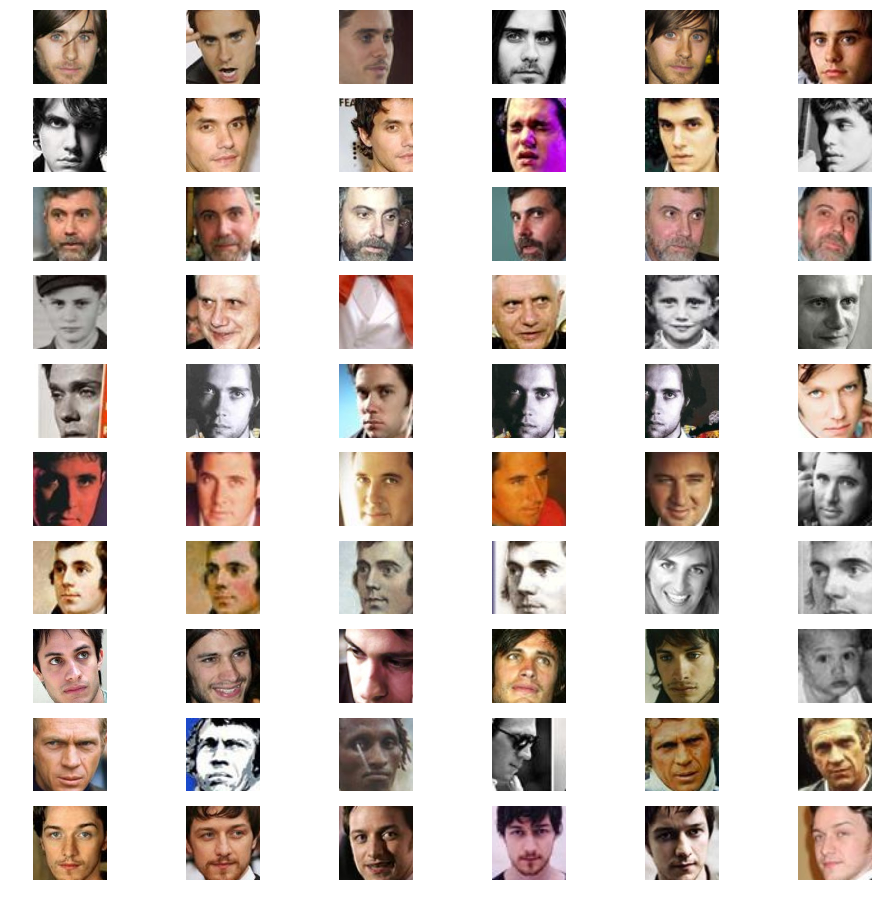

In [190]:
plt.rcParams['figure.figsize'] = [16, 16]
fig, ax = plt.subplots(10, 6)

i=-1

for x in top10.index:
    i = i+1
    
    j=0
    for n, file in enumerate(sorted(os.listdir(path))):
       
        if file.find(x) != -1:
                
            img = load_img(path + file)
            #img = cv.imread(path + file )
            
            ax[i, j].axis('off')
            ax[i, j].imshow(img)
                      
            j=j+1
    

Top 10 Silvia

In [191]:
top10 = df.groupby(df.index).max().sort_values(by = 'silvia',  ascending=False).head(10)

In [192]:
top10

,giacomo,silvia
kylie minogue,0.146381,0.986207
bridget hall,0.357802,0.983073
joanna newsom,0.117169,0.981476
leslie bibb,0.247497,0.980829
gaby espino,0.163575,0.979212
meg ryan,0.550755,0.978310
andrea corr,0.636127,0.977960
anne taintor,0.417168,0.977903
amy macdonald,0.105903,0.977872
evangeline lilly,0.843641,0.977423


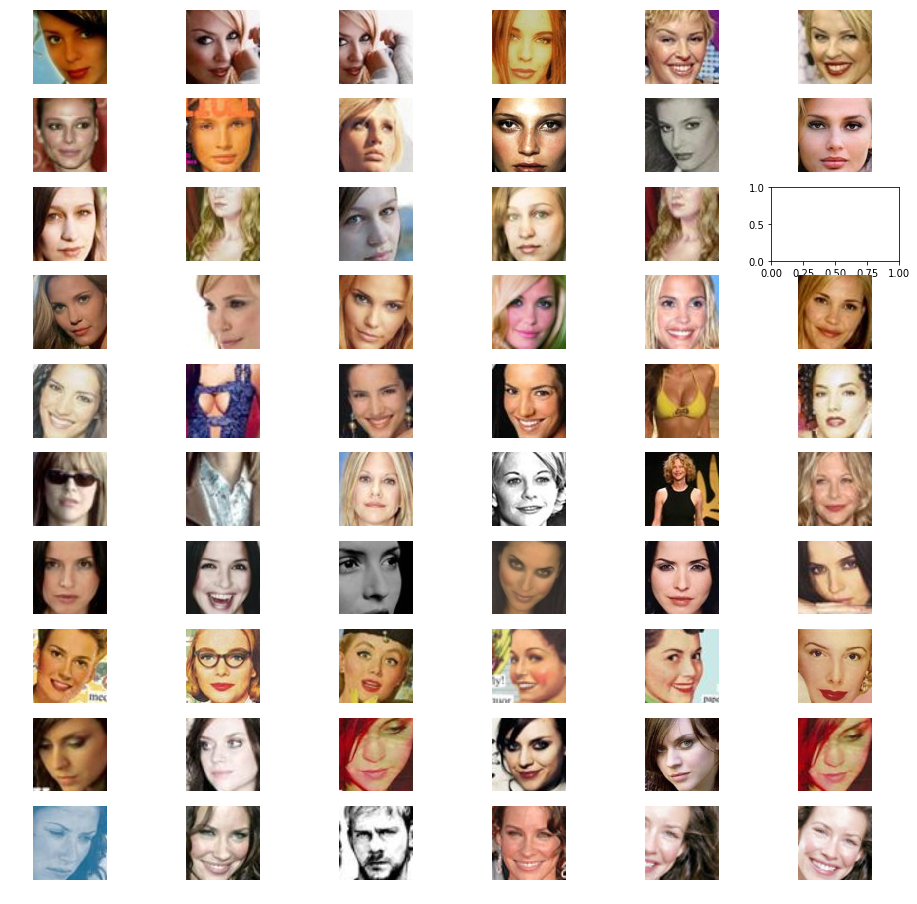

In [194]:
plt.rcParams['figure.figsize'] = [16, 16]
fig, ax = plt.subplots(10, 6)

i=-1

for x in top10.index:
    i = i+1
    
    j=0
    for n, file in enumerate(sorted(os.listdir(path))):
       
        if file.find(x) != -1:
                
            img = load_img(path + file)
            #img = cv.imread(path + file )
            
            ax[i, j].axis('off')
            ax[i, j].imshow(img)
                      
            j=j+1